In [ ]:
# !pip install geopy
# !pip install folium
# !pip install geopandas
# !pip install eli5

In [1]:
!pip install shap

In [2]:
!pip install xgboost --upgrade

In [ ]:
# ! git clone https://github.com/johan/world.geo.json/blob/master/countries/USA/WA.geo.json

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns; sns.set()
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from scipy import stats
import pickle
# from sklearn.preprocessing import PowerTransformer
housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')

# large_housing = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing.csv')
# large_housing = large_housing.drop(["id", 'date'], axis=1)
housing = housing.drop(['date','zipcode'], axis=1)
# housing = pd.get_dummies(data=housing, columns=['zipcode'],dtype=int)
housing = housing.query('price < 1272303')
housing['price'] = np.log(housing['price'])

# pt = PowerTransformer()
# housing['price'] = pd.DataFrame(pt.fit_transform(housing[['price']]), columns=['price'])


In [4]:
housing = housing.drop(['id'], axis=1) #I did this here so I could potentially use ID to re-add two models back together

In [5]:
X = housing.loc[:, housing.columns != 'price'] # Features are all the columns minus the target
y = housing.price

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# params = { 'subsample': [.1,.3,.5,.6,.8],
#            'reg_lambda': [1, 3, 5,20,30],
#            'n_estimators': [50,200, 500, 1000],
#            'colsample_bytree': [0.3, 0.7],
#             'max_depth': [3,6,7,8,10],
#             'min_child_weight': [0,.1,.3,.5,.9,1,5,10,25,50,100],
#             'seed': [0,1,3,7,10,50,100,1000],
#           'gamma': [0,.1,.01,.001,.5,1,2,5,10]
# }

In [6]:
model = XGBRegressor(learning_rate=0.1, objective='reg:squarederror', eval_metric='rmse',subsample = 0.6, seed = 3, reg_lambda = 20, n_estimators = 200, min_child_weight = 0, max_depth = 10, gamma = 0.1, colsample_bytree = 0.7)
#{'subsample': 0.6, 'seed': 3, 'reg_lambda': 20, 'n_estimators': 200, 'min_child_weight': 0, 'max_depth': 10, 'gamma': 0.1, 'colsample_bytree': 0.7}
# model = XGBRegressor(learning_rate=0.1, objective='reg:squarederror', eval_metric='rmse')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# result = mean_squared_error(y_test,predictions, squared=False)
result = mean_squared_error(np.exp(y_test), np.exp(predictions), squared=False)
housing['price'] = np.exp(housing['price'])
result


80570.87360234802

In [7]:
np.exp(predictions)

array([226849.2 , 542890.1 , 763176.9 , ..., 218715.6 , 600641.56,
       384800.47], dtype=float32)

In [8]:
filename = 'housing_model.sav'
pickle.dump(model, open(filename, 'wb')) 

loaded_model = pickle.load(open(filename, 'rb'))

Loading in our new data to be used with our saved model

In [9]:
holdout = pd.read_csv('https://raw.githubusercontent.com/byui-cse/cse450-course/master/data/housing_holdout_test.csv')

In [10]:
holdout = holdout.drop(['id', 'date','zipcode'], axis=1)

In [11]:
holdout.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15
0,4,2.25,2070,8893,2.0,0,0,4,8,2070,0,1986,0,47.4388,-122.162,2390,7700
1,5,3.00,2900,6730,1.0,0,0,5,8,1830,1070,1977,0,47.6784,-122.285,2370,6283
2,4,2.50,3770,10893,2.0,0,2,3,11,3770,0,1997,0,47.5646,-122.129,3710,9685
3,3,3.50,4560,14608,2.0,0,2,3,12,4560,0,1990,0,47.6995,-122.228,4050,14226
4,3,2.50,2550,5376,2.0,0,0,3,9,2550,0,2004,0,47.6647,-122.083,2250,4050


In [12]:
y_pred = loaded_model.predict(holdout)
y_pred = np.exp(y_pred)
np.savetxt("new_housing_data_predictions.csv", y_pred, delimiter=",")

In [ ]:
# clf = RandomizedSearchCV(estimator=model, param_distributions = params, 
#                    scoring='neg_mean_squared_error', 
#                    verbose=3,
#                    n_iter = 200)

In [ ]:
# clf.fit(X_train, y_train)

In [ ]:
# print( clf.best_params_)
# print('2')
# print(clf.best_score_)

{'subsample': 0.6, 'seed': 3, 'reg_lambda': 20, 'n_estimators': 200, 'min_child_weight': 0, 'max_depth': 10, 'gamma': 0.1, 'colsample_bytree': 0.7}
2
-0.026975972036202146


In [13]:
result = model.score(X_test, y_test)
result

0.873020466707032

In [14]:
housing.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,price
0,4,3.25,3760,4675,2.0,0,0,3,8,2740,1020,2007,0,47.3862,-122.048,3280,4033,429900.0
1,3,1.75,1460,7800,1.0,0,0,2,7,1040,420,1979,0,47.3035,-122.382,1310,7865,233000.0
2,4,1.00,1340,5800,1.5,0,2,3,7,1340,0,1914,0,47.5658,-122.389,1900,5800,455000.0
3,3,1.75,1440,8050,1.0,0,0,3,8,1440,0,1985,0,47.3187,-122.390,1790,7488,258950.0
4,2,1.50,1780,4750,1.0,0,0,4,7,1080,700,1947,0,47.6859,-122.395,1690,5962,555000.0


In [15]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


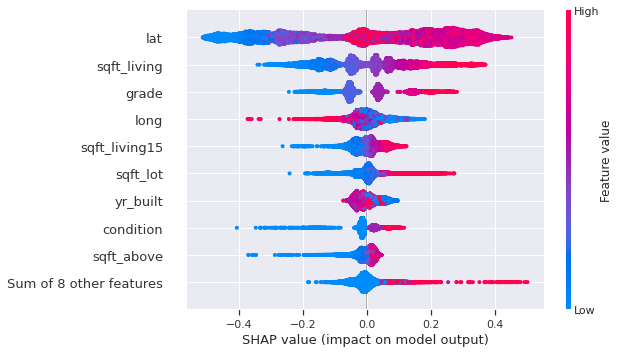

In [ ]:
shap.initjs()
shap.plots.beeswarm(shap_values)

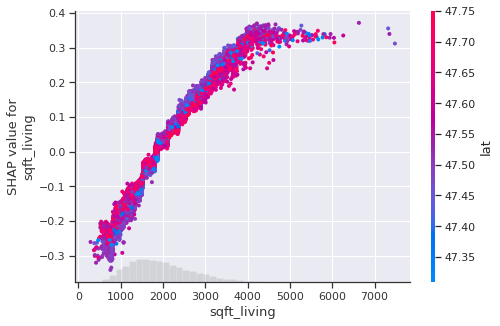

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"sqft_living"], color=shap_values)

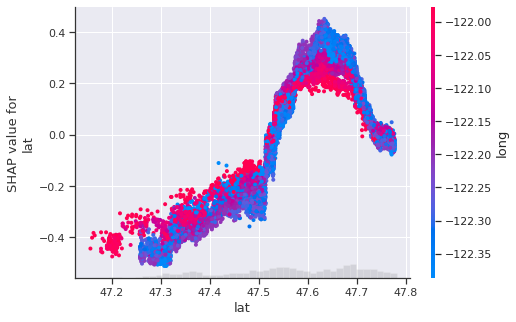

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"lat"], color=shap_values)

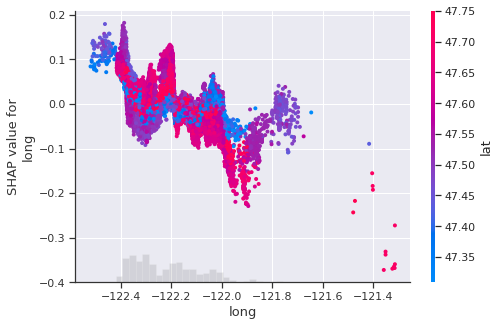

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"long"], color=shap_values)

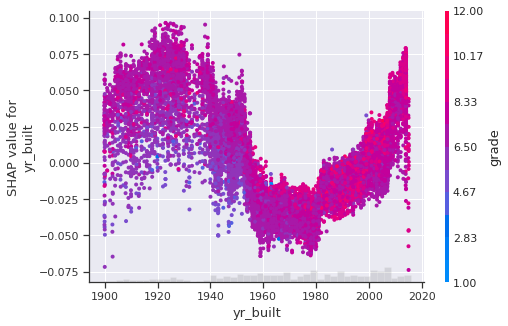

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"yr_built"], color=shap_values)

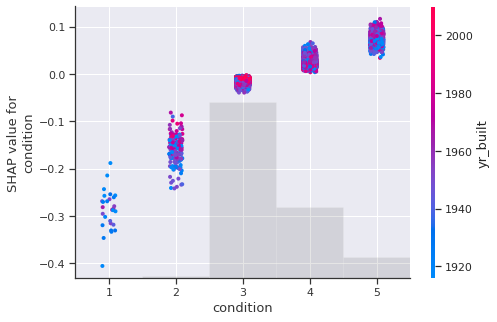

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"condition"], color=shap_values)

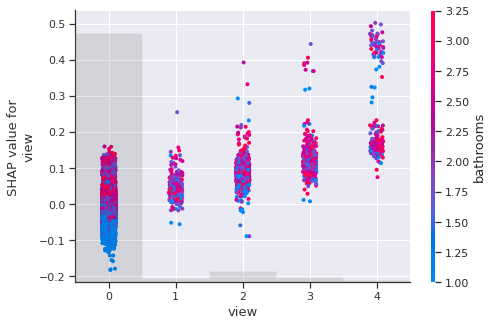

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"view"], color=shap_values)

#Random Tests. (warning... its chaos below)

In [ ]:
X=housing.loc[:,['id','lat','long']]
kmeans = KMeans(n_clusters = 40, init ='k-means++')
kmeans.fit(X[['lat','long']]) # Compute k-means clustering.
X['cluster_label'] = kmeans.fit_predict(X[['lat','long']])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(X[['lat','long']]) # Labels of each point
X.head(10)

KeyError: ignored

In [ ]:
X.plot.scatter(x = 'lat', y = 'long', c=labels, s=50, cmap='viridis')
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5) f

NameError: ignored

In [ ]:
X = X[['id','cluster_label']]
housing = housing.merge(X, left_on='id', right_on='id')
housing['cluster_label'] = pd.Categorical(housing['cluster_label'])
housing.head(5)


In [ ]:
housing.dtypes

In [ ]:
housing = housing.drop(['id'], axis=1)

In [ ]:
# housing = housing.drop(['id'], axis=1)
# housing = housing.drop(['lat','long'], axis=1)
housing = pd.get_dummies(data=housing, columns=['cluster_label'],dtype=int)
# housing = housing.drop(['id','zipcode','cluster_label'], axis=1)

In [ ]:
X = housing.loc[:, housing.columns != 'price'] # Features are all the columns minus the target
y = housing.price

X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:

# import folium
# from branca.element import Figure
# fig=Figure(width=550,height=350)
# m1=folium.Map(width=550,height=350,location=[47.751076, -120.7401],zoom_start=6,min_zoom=2,max_zoom=14)
# m1
# # optional: save the map.
# # map_pickup.save('map_pickup.html')

In [ ]:
# import re

# # For working with geographical data
# import geopandas
# WA_geojson=geopandas.read_file('/content/WA.geo.json')
# WA_geojson.head()
# WA_geojson.plot()

In [ ]:
# locations = housing[['lat', 'long']]
# locationlist = locations.values.tolist()
# import folium
# for point in range(0, len(locationlist)):
#     folium.Marker(locationlist[point]).add_to(m1)
# m1


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
params = { 'subsample': [.1,.3,.5,.6,.8],
           'reg_lambda': [1, 3, 5,20,30],
           'n_estimators': [50,200, 500, 1000],
           'colsample_bytree': [0.3, 0.7],
            'max_depth': [3,6,7,8,10],
            'min_child_weight': [0,.1,.3,.5,.9,1,5,10,25,50,100],
            'seed': [0,1,3,7,10,50,100,1000],
          'gamma': [0,.1,.01,.001,.5,1]
}

In [ ]:
model = XGBRegressor(learning_rate=0.1, objective='reg:squarederror', eval_metric='rmse')
model.fit(X_train, y_train)
predictions = model.predict(X_test)
# result = mean_squared_error(y_test,predictions, squared=False)
result = mean_squared_error(np.exp(y_test), np.exp(predictions), squared=False)
housing['price'] = np.exp(housing['price'])
result

In [ ]:
clf = RandomizedSearchCV(estimator=model, param_distributions = params, 
                   scoring='neg_mean_squared_error', 
                   verbose=3,
                   n_iter = 100)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print( clf.best_params_)
print('2')
print(clf.best_score_)

In [ ]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer(X)

In [ ]:
shap.initjs()
shap.plots.waterfall(shap_values[0])

In [ ]:
shap.initjs()
shap.plots.force(shap_values[0])

In [ ]:
shap.initjs()
shap.plots.bar(shap_values)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values.values[0:5,:],X.iloc[0:5,:], plot_cmap="DrDb")

In [ ]:
shap.initjs()
shap.plots.scatter(shap_values[:,"sq_"], color=shap_values)

In [ ]:
shap.initjs()
shap.plots.beeswarm(shap_values)

In [ ]:
clf = RandomizedSearchCV(estimator=model, param_distributions = params, 
                   scoring='neg_mean_squared_error', 
                   verbose=3,
                   n_iter = 100)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
print( clf.best_params_)
print('2')
print(clf.best_score_)

In [ ]:
# predictions = model.predict(X_test)
# result = mean_squared_error(y_test, predictions, squared=False)
# result

In [ ]:
filename = 'housing_model.sav'
pickle.dump(model, open(filename, 'wb')) 

loaded_model = pickle.load(open(filename, 'rb'))

In [ ]:
result = model.score(X_test, y_test)
result

In [ ]:
result = r2_score(y_test, predictions)
result

In [ ]:
sns.countplot(x=housing["price"],palette='mako');

In [ ]:
import plotly.express as px

fig = px.scatter_geo(housing,lat='lat',lon='long', projection = "albers usa", locationmode='USA-states')
fig.update_layout(title = 'washington', title_x=0.5)
fig.show()

In [ ]:
#Even though this comes enabled, sometimes it acts up The whole point is that now you don't need to use plt.show()
%matplotlib inline 
correlations = housing.corr()
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(correlations)
# sns.heatmap(correlations)

In [ ]:
heatmap = sns.heatmap(housing.corr()[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating directly to price', fontdict={'fontsize':18}, pad=16);

In [ ]:
new_correlation = housing.corr()

In [ ]:
housing.dtypes

In [ ]:
#Even though this comes enabled, sometimes it acts up The whole point is that now you don't need to use plt.show()
%matplotlib inline 
import seaborn as sns
import matplotlib.pyplot as plt
sns.heatmap(new_correlation)

In [ ]:
new_correlation['bedrooms']

In [ ]:
heatmap = sns.heatmap(upper)

In [ ]:
print(new_correlation['price'])

In [ ]:
sns.set(rc = {'figure.figsize':(20,20)})
# heatmap = sns.heatmap(new_correlation[['price']].sort_values(by='price', ascending=False), mask=new_correlation[['price']].sort_values(by='price', ascending=False) < 0, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap = sns.heatmap(new_correlation[['price']].sort_values(by='price', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating directly to price', fontdict={'fontsize':18}, pad=16);


In [ ]:
sns.set(rc = {'figure.figsize':(20,20)})
# heatmap = sns.heatmap(new_correlation[['price']].sort_values(by='price', ascending=False), mask=new_correlation[['price']].sort_values(by='price', ascending=False) < 0, vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap = sns.heatmap(new_correlation[['zipcode_98004']].sort_values(by='zipcode_98004', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Features Correlating directly to price', fontdict={'fontsize':18}, pad=16);


In [ ]:

f, ax = plt.subplots(figsize=(7, 7))
ax.set(xscale="log")
sns.histplot(data=housing, x='price', palette='mako')

In [ ]:
housing.isnull().values.any()

In [ ]:
# import sklearn
# X = housing.loc[:, housing.columns != 'price'] # Features are all the columns minus the target
# y = housing.price

# X_test, X_train, y_test, y_train = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
len(y_test)

In [ ]:
len(predictions)

In [ ]:
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)
feature_imp
feature_imp = pd.Series(model.feature_importances_,index=X.columns).sort_values(ascending=False)

feature_imp.plot.bar()

In [ ]:
# feature_imp2 = pd.Series(model_2.feature_importances_,index=l_X.columns).sort_values(ascending=False)
# feature_imp2
# feature_imp2 = pd.Series(model_2.feature_importances_,index=l_X.columns).sort_values(ascending=False)

# feature_imp2.plot.bar()